In [2]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [3]:
ds_train=pd.read_csv("train_hora.csv")
ds_train["date"]=pd.to_datetime(ds_train["date"],format="%Y-%m-%d %H:%M:%S")
ds_train=ds_train.set_index("date")
ds_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2018-01-01 00:00:00 to 2021-12-31 23:00:00
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   consumption  35064 non-null  float64
dtypes: float64(1)
memory usage: 547.9 KB


In [4]:
ds_test=pd.read_csv("test_hora.csv")
ds_test["date"]=pd.to_datetime(ds_test["date"],format="%Y-%m-%d %H:%M:%S")
ds_test=ds_test.set_index("date")
ds_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2022-01-01 00:00:00 to 2022-12-31 23:00:00
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   consumption  8760 non-null   float64
dtypes: float64(1)
memory usage: 136.9 KB


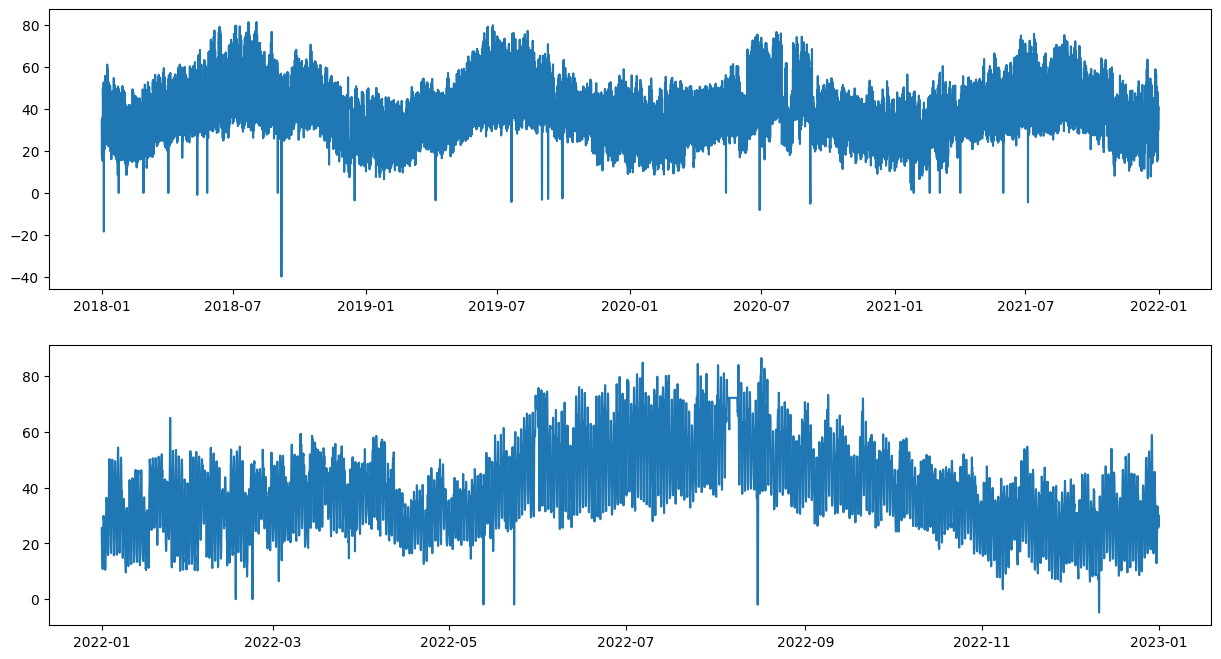

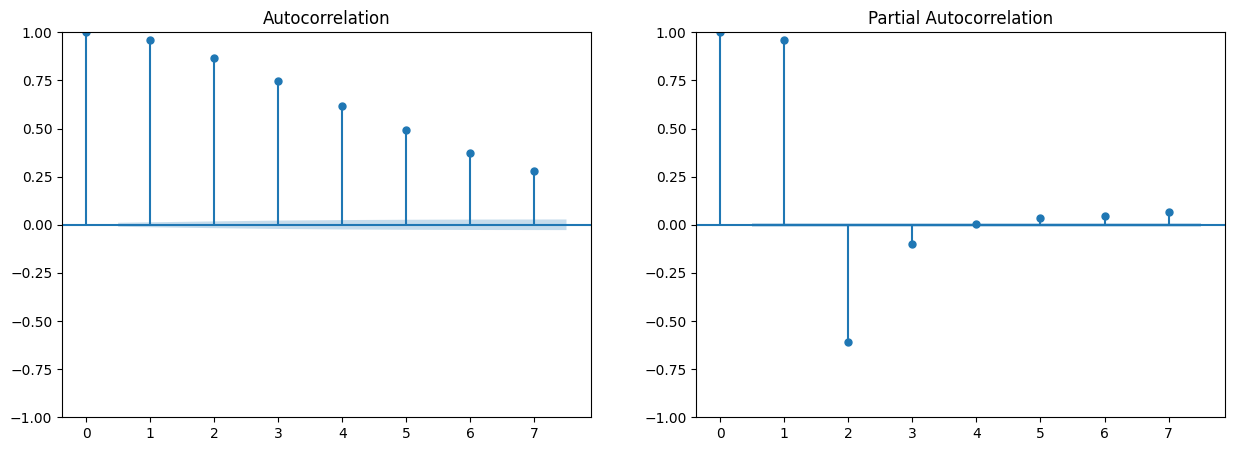

In [5]:
ym=ds_train["consumption"].to_numpy()
xm=ds_train.index.to_numpy()
ytm=ds_test["consumption"].to_numpy()
xtm=ds_test.index.to_numpy()
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
axes[0].plot(xm,ym);
axes[1].plot(xtm,ytm);
fig, axes = plt.subplots(1,2)
fig.set_size_inches(15, 5)
plot_acf(ym,lags=7,ax=axes[0]);
plot_pacf(ym,lags=7,method="ywm",ax=axes[1]);


Revisión de Datos Faltantes

In [6]:
deltas = 365*24*4
#agregamos un día al rango por el año bisiesto 2020
deltas+=24
start = datetime.datetime.strptime("2018-01-01 00:00:00", '%Y-%m-%d %H:%M:%S')
train_full = [start + datetime.timedelta(hours=x) for x in range(deltas)]
deltas = 365*24
start = datetime.datetime.strptime("2022-01-01 00:00:00", '%Y-%m-%d %H:%M:%S')
test_full = [start + datetime.timedelta(hours=x) for x in range(deltas)]
missing_train=[]
for fecha in train_full:
    if not (fecha in ds_train.index):
        missing_train.append(fecha)
missing_test=[]
for fecha in test_full:
    if not (fecha in ds_test.index): 
        missing_test.append(fecha)
print(len(train_full),len(ds_train),len(missing_train))
print(len(test_full),len(ds_test),len(missing_test))
for missing in missing_test:
    print(missing.strftime('%Y-%m-%d %H:%M:%S')) 

35064 35064 0
8760 8760 0


In [7]:
result = adfuller(ym)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.436962
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [8]:
import tensorflow as tf
from datetime import datetime
from tensorflow import keras
from keras.layers import SimpleRNN, LSTM, Input, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import random as rd

2024-05-01 15:38:02.869213: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
yw=[]
yt=[]
window=216
for i in range(0,len(ym)):
    if i+window < len(ym):
        row=[]
        for j in range(48):
            row.append(ym[i+j])
        yw.append(row)
        row=[]
        for j in range(168):
            row.append(ym[i+48+j])
        yt.append(row)
    else:
        break
print(len(yw))
yw=np.asarray(yw)
yt=np.asarray(yt)

34848


In [10]:
yw_test=[]
yt_test=[]
window=216
for i in range(0,len(ytm)):
    if i+window < len(ytm):
        row=[]
        for j in range(48):
            row.append(ytm[i+j])
        yw_test.append(row)
        row=[]
        for j in range(168):
            row.append(ytm[i+48+j])
        yt_test.append(row)
    else:
        break
print(len(yw_test))
yw_test=np.asarray(yw_test)
yt_test=np.asarray(yt_test)

8544


In [23]:
t_media=pd.read_csv("temperaturas/DMC_330020_Quinta_Normal_Santiago_media.csv",sep=";")
t_media["date"]=pd.to_datetime(t_media["date"],format="%Y-%m-%d %H:%M:%S")
t_media=t_media.set_index("date")
t_media=t_media.query("date.dt.year>2017 and date.dt.year<2023")
t_media.head()

,valor
date,
2018-01-01,20.2
2018-01-02,21.1
2018-01-03,22.3
2018-01-04,21.9
2018-01-05,22.2


In [24]:
t_minima=pd.read_csv("temperaturas/DMC_330020_Quinta_Normal_Santiago_minima.csv",sep=";")
t_minima["date"]=pd.to_datetime(t_minima["date"],format="%Y-%m-%d %H:%M:%S")
t_minima=t_minima.set_index("date")
t_minima=t_minima.query("date.dt.year>2017 and date.dt.year<2023")
t_minima.head()

,valor
date,
2018-01-01,12.8
2018-01-02,12.4
2018-01-03,12.1
2018-01-04,14.1
2018-01-05,15.4


In [25]:
t_maxima=pd.read_csv("temperaturas/DMC_330020_Quinta_Normal_Santiago_maxima.csv",sep=";")
t_maxima["date"]=pd.to_datetime(t_maxima["date"],format="%Y-%m-%d %H:%M:%S")
t_maxima=t_maxima.set_index("date")
t_maxima=t_maxima.query("date.dt.year>2017 and date.dt.year<2023")
t_maxima.head()

,valor
date,
2018-01-01,28.9
2018-01-02,30.2
2018-01-03,31.6
2018-01-04,31.7
2018-01-05,30.0


In [28]:
print(len(t_minima),len(t_media),len(t_maxima),365*5+1)

1826 1826 1826 1826


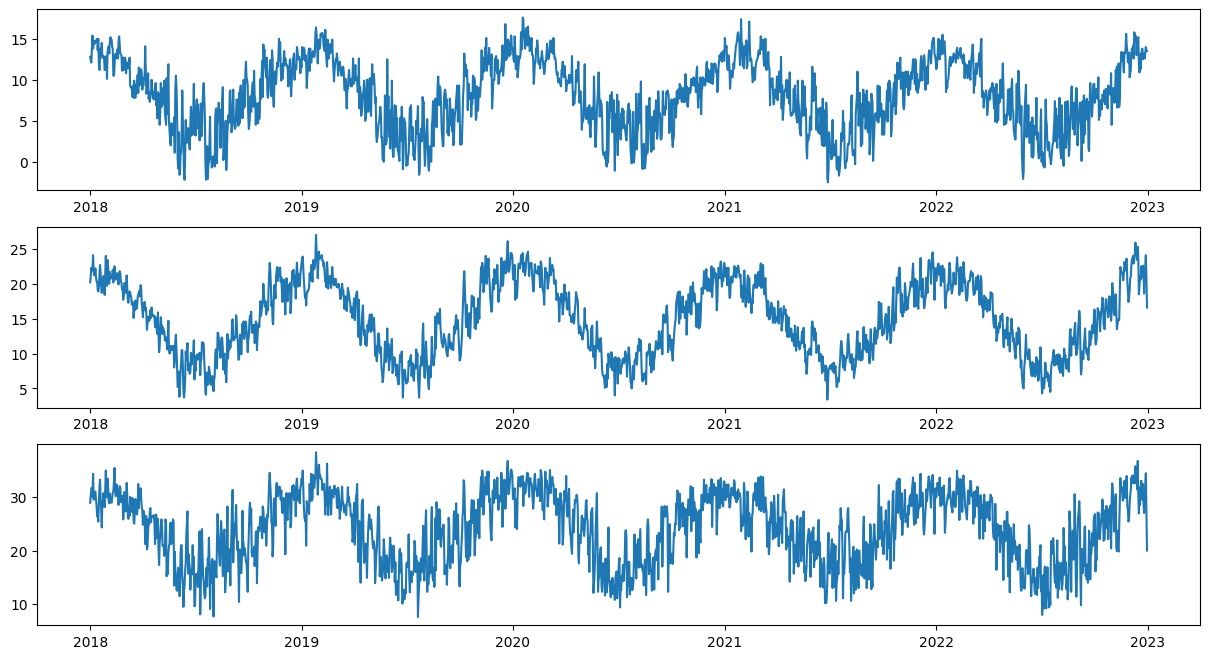

In [30]:
fig, axes = plt.subplots(3,1)
fig.set_size_inches(15, 8)
axes[0].plot(t_minima.index,t_minima);
axes[1].plot(t_media.index,t_media);
axes[2].plot(t_maxima.index,t_maxima)